# Image Classification: EuroSAT Land Use and Land Cover Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lukas-gysin/bverl-miniproject/blob/main/notebooks/00-submission.ipynb)

Submission of the group **GeoGuesser**
by Julian Steinacher and Lukas Gysin

In [1]:
%%capture
%pip install lightning torchinfo torchshow

In [18]:
# Python Standard Library
import os
from pathlib import Path

# Third Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import functional as tvF
from torchvision.transforms import Normalize

In [3]:
# Import geoguesser library
try:
  import geoguesser
  print("package installed, all good")
except ImportError as e:
  print("Installing from git repo")
  os.system("pip install git+https://github.com/lukas-gysin/bverl-miniproject")

from geoguesser.classifier import Classifier
from geoguesser.dataset import EuroSATDataset
from geoguesser.dataset import EuroSATDataLoader
from geoguesser.trainer import Trainer

Installing from git repo


In [4]:
# Global Configuration
seed = 1234

sns.set_theme()

## Introduction

## Data

In [5]:
dataset_ms = EuroSATDataset.download(dataset='MS')
dataset_rgb = EuroSATDataset.download(dataset='RGB')

# Normalize MS Dataset, since some channels have really big values
values = {}
for channel in range(dataset_ms[0]['image'].size(0)):
  values[channel] = []

for idx in range(min(len(dataset_ms), 1_000)):
  observation = dataset_ms[idx]
  for channel in range(observation['image'].size(0)):
    values[channel].append(observation['image'][channel].mean())

means = []
stds = []
for channel in range(dataset_ms[0]['image'].size(0)):
  means.append(np.mean(values[channel]))
  stds.append(np.std(values[channel]))

ids = [i for i in range(len(dataset_ms))]
dataset_ms = EuroSATDataset.from_subset(dataset_ms, ids, transform=Normalize(mean=means, std=stds))

Starting download from https://zenodo.org/records/7711810/files/EuroSAT_MS.zip?download=1
Dataset downloaded and saved to /workspace/code/data/MS.zip
Starting extracting dataset to /workspace/code/data/MS
Dataset extracted to /workspace/code/data/MS
Starting download from https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1
Dataset downloaded and saved to /workspace/code/data/RGB.zip
Starting extracting dataset to /workspace/code/data/RGB
Dataset extracted to /workspace/code/data/RGB
Created a subset with 27_000 of 27_000 images


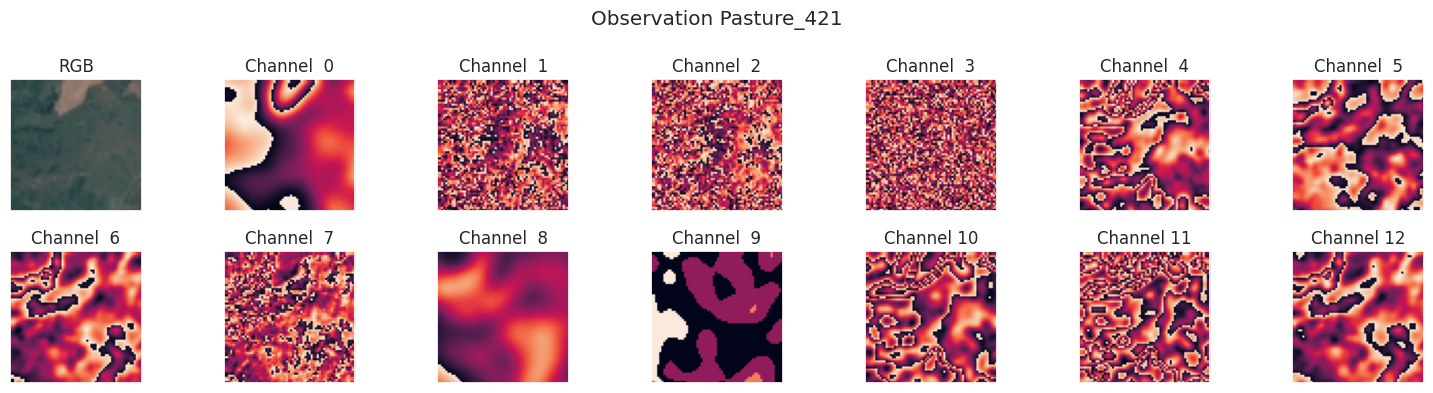

In [6]:
fig, axs = plt.subplots(figsize=(16, 4), ncols=7, nrows=2, layout='tight')
axs = axs.flatten()

observation_ms = dataset_ms[17_000]
observation_rgb = dataset_rgb.get(observation_ms['file'])

fig.suptitle(f'Observation {observation_rgb["file"]}')

axs[0].imshow(tvF.to_pil_image(pic=observation_rgb['image']))
_ = axs[0].set_title(f'RGB')
_ = axs[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

for channel in range(observation_ms['image'].size(0)):
  axs[channel+1].imshow(tvF.to_pil_image(pic=observation_ms['image'][channel]))
  _ = axs[channel+1].set_title(f'Channel {channel:2}')
  _ = axs[channel+1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


The data consists of 27000 datasets containing a label, a RGB Image and a TIF image containing additional 13 Channels. The images are made from a satellite. These datasets are can be found separated on zenodo. They are already delivered in a folder structure where every image is in a folder for their label. Each image has a resolution of 64 by 64. However some channels of the tif image are upsampled to get to this resolution. Each pixel covers 10 meters of land.

The images are divided into 10 labels with each label having at least 2000 datasets:
*  'SeaLake' => 3000 sets
* 'Pasture' => 2000 sets
*  'River' => 2500 sets
* 'PermanentCrop' => 2500 sets
*  'Residential' => 3000 sets
*  'Industrial' => 2500 sets
*  'HerbaceousVegetation' => 3000sets
* 'AnnualCrop' => 3000 sets
* 'Highway' => 2500 sets
* 'Forest' => 3000 sets



<ipython-input-12-4d318ae499ba>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(tick_labels, rotation=15, ha='right')


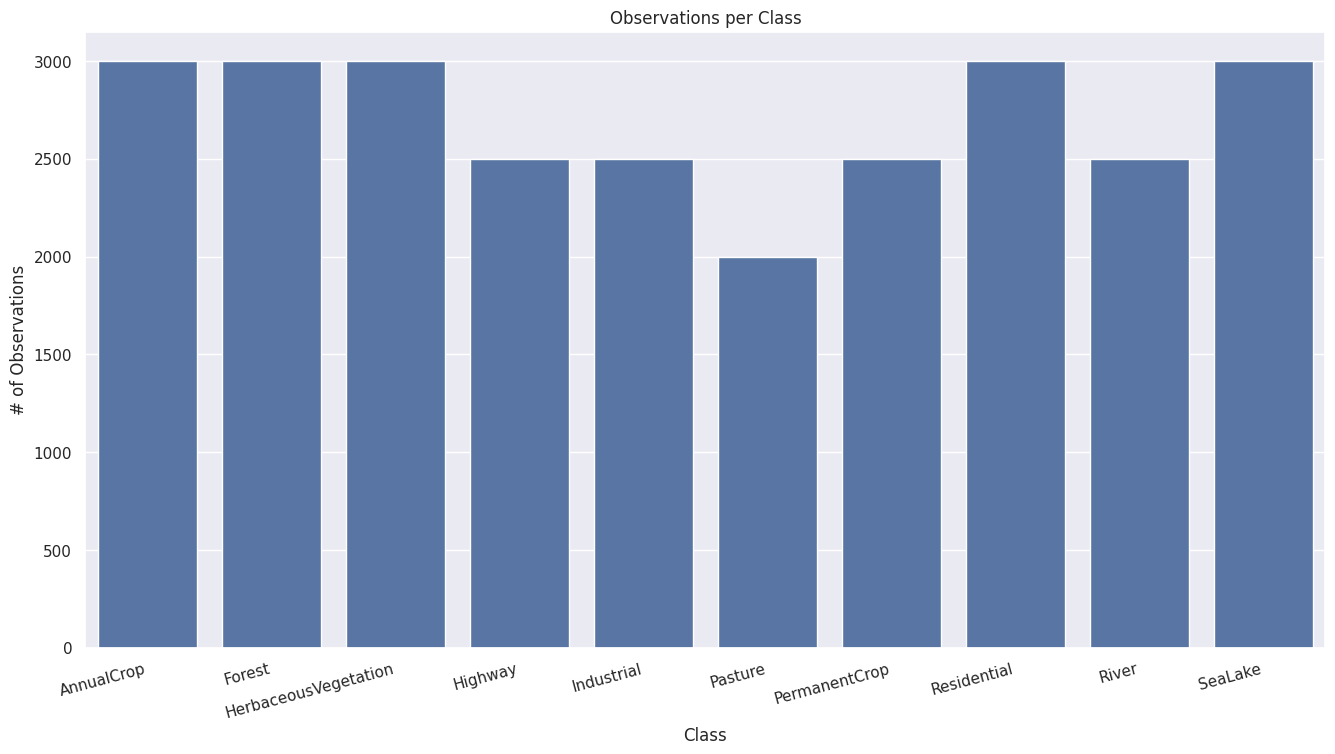

In [12]:
labels = [x["label"] for x in dataset_rgb.observations]

label_order = list(set(labels))
label_order.sort()

labels_count = {}
for label in labels:
  if label in labels_count:
    labels_count[label] += 1
  else:
    labels_count[label] = 1

fig, ax = plt.subplots(figsize=(16, 8))

ax = sns.barplot(data=labels_count, order=label_order, errorbar=None, ax=ax)
_ = ax.set_title("Observations per Class")
_ = ax.set_xlabel("Class")
_ = ax.set_ylabel("# of Observations")
tick_labels = ax.get_xticklabels()
_ = ax.set_xticklabels(tick_labels, rotation=15, ha='right')

In [8]:
dataloaders_rgb = EuroSATDataLoader(dataset_rgb, seed=seed)
dataloader_rgb_train = dataloaders_rgb.training(transformer=Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), batch_size=64)
dataloader_rgb_val = dataloaders_rgb.validation(transformer=Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), batch_size=64)
dataloader_rgb_test = dataloaders_rgb.testing(transformer=Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))

dataloaders_ms = EuroSATDataLoader(dataset_ms, seed=seed)
dataloader_ms_train = dataloaders_ms.training(batch_size=64)
dataloader_ms_val = dataloaders_ms.validation(batch_size=64)
dataloader_ms_test = dataloaders_ms.testing()


Created a subset with 21_600 of 27_000 images
Created a subset with 2_700 of 27_000 images
Created a subset with 2_700 of 27_000 images
Created a subset with 21_600 of 27_000 images
Created a subset with 2_700 of 27_000 images
Created a subset with 2_700 of 27_000 images


## Models

In [9]:
model_results = {}

In [10]:
# Python Standard Library
from pathlib import Path

# Third Party Libraries
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger


class Trainer(L.Trainer):
  def __init__(self, seed, experiment_name):
    L.seed_everything(seed)
    logger = CSVLogger(Path('/workspace/code/data/logs'), name=experiment_name, version=0)
    early_stopping = EarlyStopping(monitor="val/acc_epoch", mode="max", patience=5)
    super().__init__(
        max_epochs=50,
        devices="auto",
        accelerator="auto",
        logger=logger,
        default_root_dir=Path('/workspace/code/data/logs'),
        callbacks=[early_stopping],
    )

In [14]:
class Lecture(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, 5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

lecture_net_rgb = Lecture(input_channels=dataset_rgb.channels())
experiment_name='lecture_rgb'
lecture_classifier_rgb = Classifier(lecture_net_rgb)
trainer = Trainer(seed, experiment_name=experiment_name)
trainer.fit(lecture_classifier_rgb, train_dataloaders=dataloader_rgb_train, val_dataloaders=dataloader_rgb_val)
model_results[experiment_name] = {
    'experiment': experiment_name,
    'dataset': 'rgb',
    'parameters': sum(parameter.numel() for parameter in lecture_classifier_rgb.parameters() if parameter.requires_grad),
    'accuracy': trainer.test(model=lecture_classifier_rgb, dataloaders=dataloader_rgb_test)[0]['test/acc_epoch']
}

lecture_net_ms = Lecture(input_channels=dataset_ms.channels())
experiment_name='lecture_ms'
lecture_classifier_ms = Classifier(lecture_net_ms)
trainer = Trainer(seed, experiment_name=experiment_name)
trainer.fit(lecture_classifier_ms, train_dataloaders=dataloader_ms_train, val_dataloaders=dataloader_ms_val)
model_results[experiment_name] = {
    'dataset': 'ms',
    'parameters': sum(parameter.numel() for parameter in lecture_classifier_ms.parameters() if parameter.requires_grad),
    'accuracy': trainer.test(model=lecture_classifier_ms, dataloaders=dataloader_ms_test)[0]['test/acc_epoch']
}

INFO: Seed set to 1234
INFO:lightning.fabric.utilities.seed:Seed set to 1234
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /workspace/code/data/logs/lecture_rgb/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | Le

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/acc_epoch       │           0.75            │
│       test/acc_step       │           0.75            │
└───────────────────────────┴───────────────────────────┘

INFO: Seed set to 1234
INFO:lightning.fabric.utilities.seed:Seed set to 1234
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | Lecture            | 18.4 K | train
1 | loss_fn        | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | train_loss     | MeanMetric         | 0      | train
4 | val_accuracy   | MulticlassAccuracy | 0      | train
5

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/acc_epoch       │    0.9240740537643433     │
│       test/acc_step       │    0.9240740537643433     │
└───────────────────────────┴───────────────────────────┘

## Results

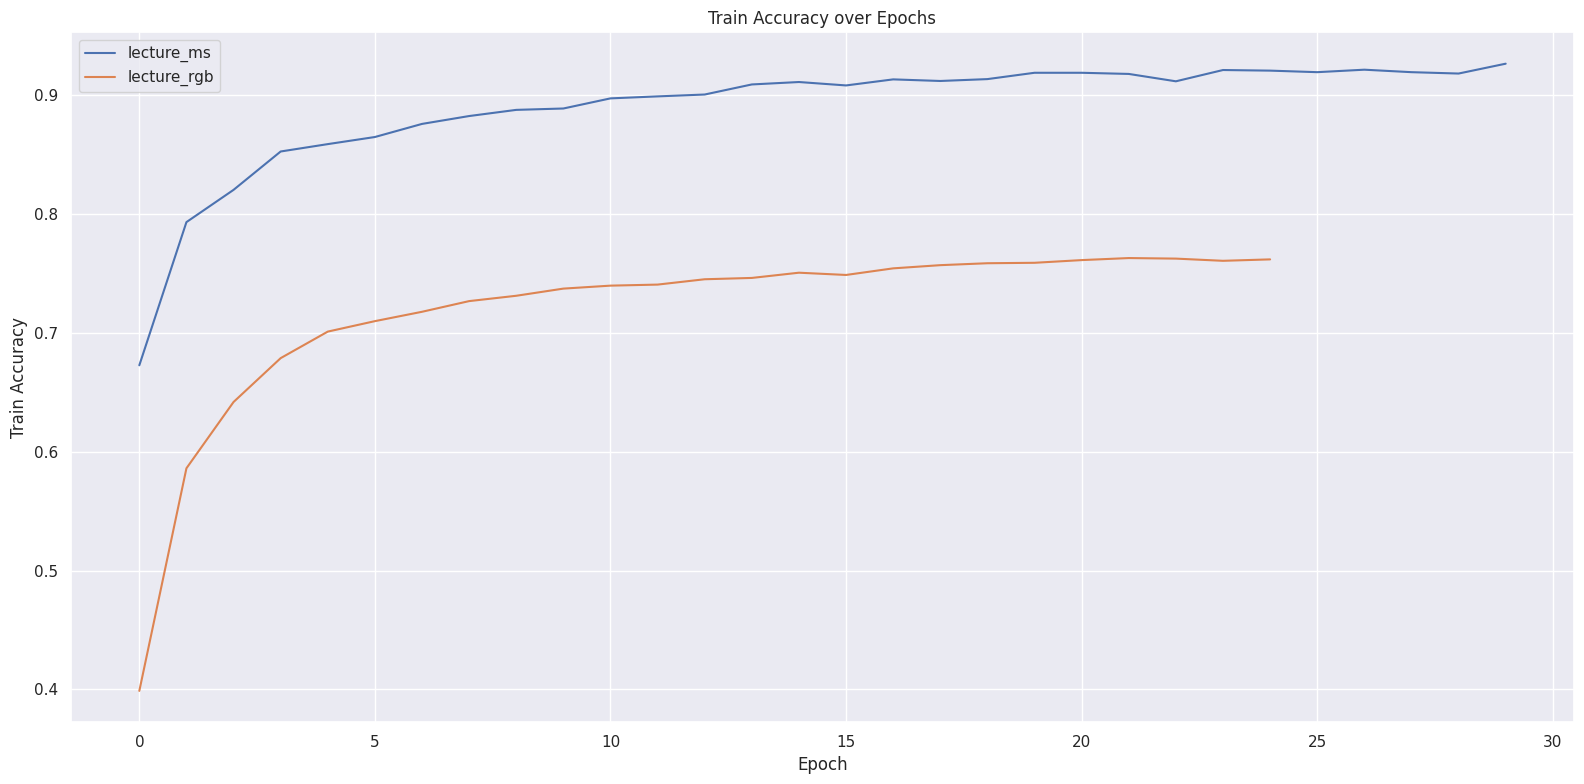

In [16]:
fig, ax = plt.subplots(figsize=(16, 8), layout='tight')
ax.set_title("Train Accuracy over Epochs")
ax.set_xlabel("Epoch")
ax.set_ylabel("Train Accuracy")

for experiment in os.listdir(Path('/workspace/code/data/logs')):
  path = Path('/workspace/code/data/logs') / experiment / 'version_0/metrics.csv'
  metrics = pd.read_csv(path)
  metrics = metrics[~metrics['train/acc_epoch'].isna()]
  ax.plot(metrics['epoch'], metrics['train/acc_epoch'], label=experiment)

_ = ax.legend()

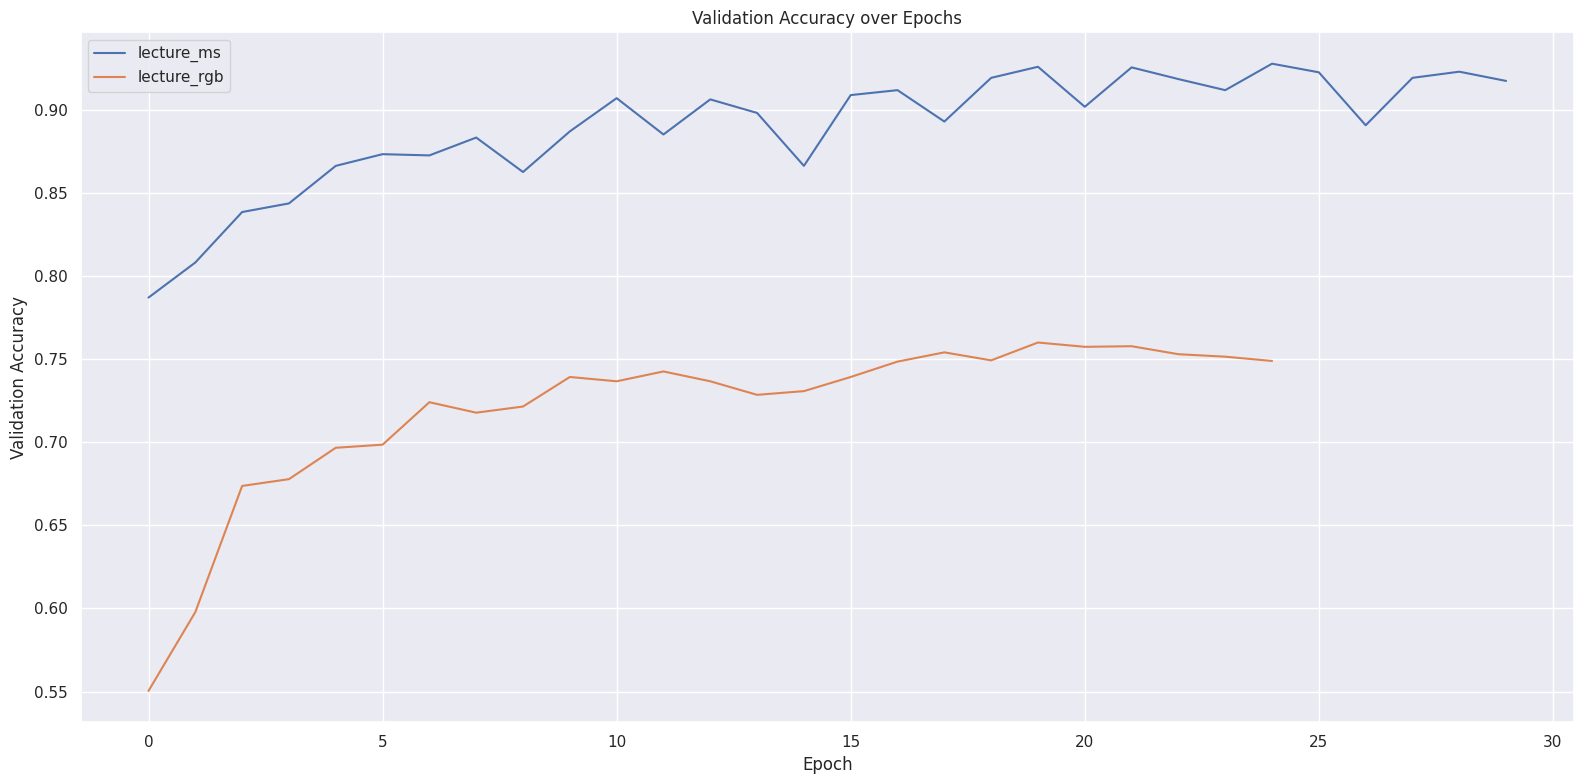

In [17]:
fig, ax = plt.subplots(figsize=(16, 8), layout='tight')
ax.set_title("Validation Accuracy over Epochs")
ax.set_xlabel("Epoch")
ax.set_ylabel("Validation Accuracy")

for experiment in os.listdir(Path('/workspace/code/data/logs')):
  path = Path('/workspace/code/data/logs') / experiment / 'version_0/metrics.csv'
  metrics = pd.read_csv(path)
  metrics = metrics[~metrics['val/acc_epoch'].isna()]
  ax.plot(metrics['epoch'], metrics['val/acc_epoch'], label=experiment)

_ = ax.legend()

TypeError: Data source must be a DataFrame or Mapping, not <class 'list'>.

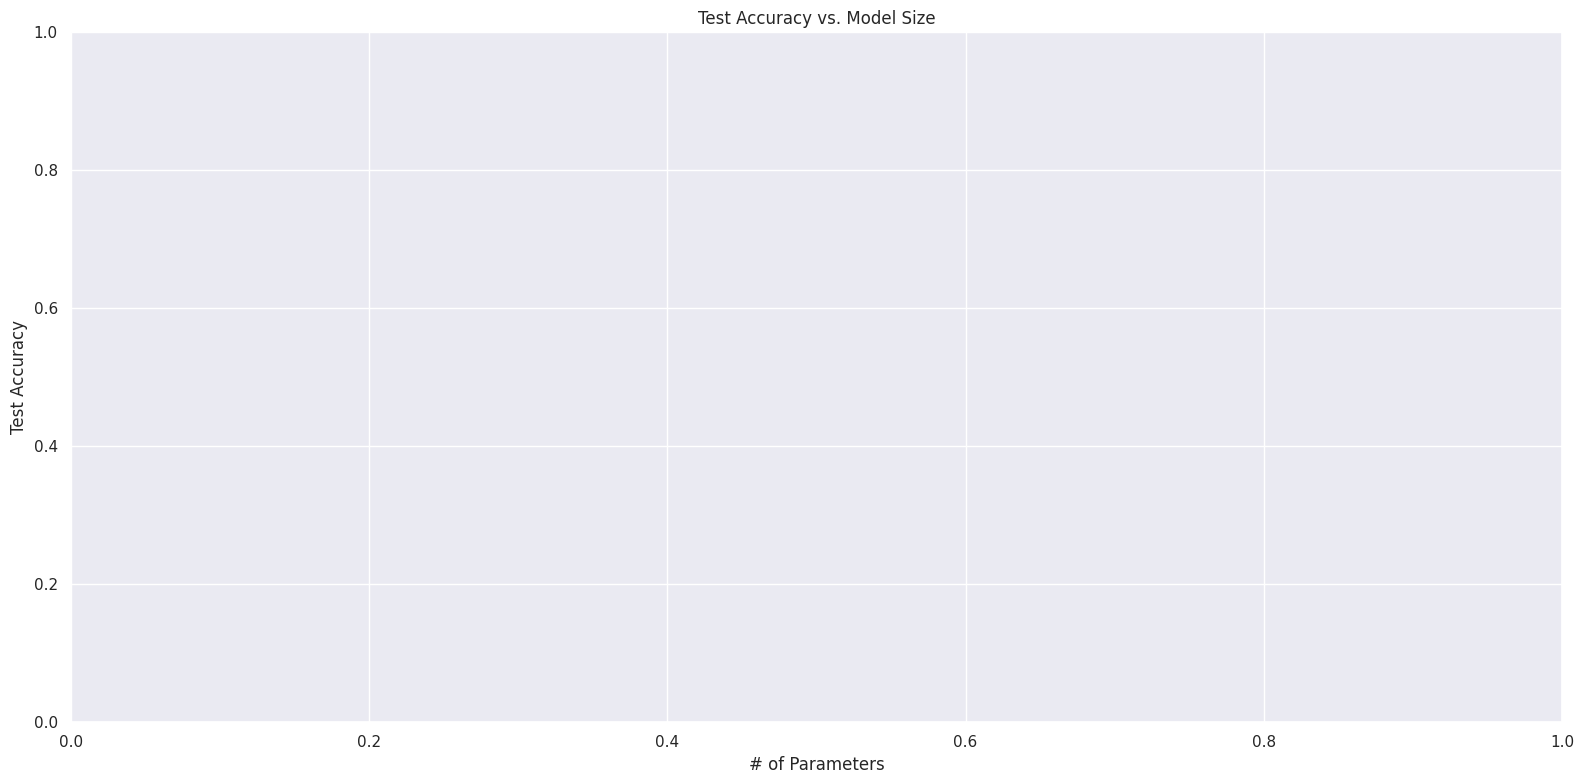

In [19]:
data = pd.DataFrame([{'experiment': name, 'dataset': details['dataset'], 'parameters': details['parameters'], 'accuracy': details['accuracy']} for name, details in model_results.items()])

fig, ax = plt.subplots(figsize=(16, 8), layout='tight')
ax.set_title("Test Accuracy vs. Model Size")
ax.set_xlabel("# of Parameters")
ax.set_ylabel("Test Accuracy")

ax = sns.scatterplot(data=data, x='parameters', y='accuracy', hue='dataset', ax=ax)

## Discussion